In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb
import sys
sys.path.append('./modified_medsam_repo')

In [2]:
def proc_pattern_for_eval_result_load(pattern, label_lambda):
    files = glob(pattern)
    listo = []
    for file in files:
        #label_num = int(file.split('/')[-1].split('label')[1].split('.pkl')[0])
        label_num = label_lambda(file)
        
        stuff = pd.read_pickle(file)
        this_list = [label_num, stuff['dice_sensitivity'].item(), stuff['dice_specificity'].item(), stuff['overall_dice'].item()]
        this_arr = np.array(this_list).reshape((1, 4))
        listo.append(this_arr)

        

    combined = np.concatenate(listo, axis = 0)
    df = pd.DataFrame(combined, columns = ['label_number', 'dice_sensitivity', 'dice_specificity', 'overall_dice'])
    df = df.sort_values('label_number').reset_index(drop=True)

    return df

In [13]:
pd.read_pickle('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retrain_dice_11-1-24/val/1/0.0005/quantile5/eval_singletask_unprompted_val_label1.pkl')

{'dice_sensitivity': tensor([0.9013]),
 'dice_specificity': tensor([0.9809]),
 'overall_dice': tensor([0.9485]),
 'label_numbers': [],
 'num_negative_examples': tensor(16489, device='cuda:0'),
 'num_positive_examples': tensor(11330, device='cuda:0')}

In [5]:
medsam_normal = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retrain_dice_11-1-24/val/*/*/eval_singletask_unprompted_val_label*.pkl'
medsam_quantile5 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retrain_dice_11-1-24/val/*/*/quantile5/eval_singletask_unprompted_val_label*.pkl'
medsam_at_least_100 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_retrain_dice_11-1-24/val/*/*/at_least_100/eval_singletask_unprompted_val_label*.pkl'



medsam_yolo_normal = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_yolo_retrain_dice_11-18-24/val/*/*/eval_singletask_yolov7_prompted_val_label*.pkl'
medsam_yolo_quantile5 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_yolo_retrain_dice_11-18-24/val/*/*/quantile5/eval_singletask_yolov7_prompted_val_label*.pkl'
medsam_yolo_at_least_100 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/medsam_yolo_retrain_dice_11-18-24/val/*/*/at_least_100_pixels/eval_singletask_yolov7_prompted_val_label*.pkl'

unet_normal = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_all_labels_9-9-24/val/*/*/eval_singletask_unet_val_label*.pkl'
unet_quantile5 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_all_labels_9-9-24/val/*/*/quantile5/eval_singletask_unet_val_label*.pkl'
unet_at_least_100 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_retrain_all_labels_9-9-24/val/*/*/at_least_100/eval_singletask_unet_val_label*.pkl'

dicto = {
    'medsam_normal': medsam_normal,
    'medsam_quantile5': medsam_quantile5,
    'medsam_at_least_100': medsam_at_least_100,
    'medsam_yolo_normal': medsam_yolo_normal,
    'medsam_yolo_quantile5': medsam_yolo_quantile5,
    'medsam_yolo_at_least_100': medsam_yolo_at_least_100,
    'unet_normal': unet_normal,
    'unet_quantile5': unet_quantile5,
    'unet_at_least_100': unet_at_least_100
}

dicto2 = {}
for ke in dicto.keys():
    dicto2[ke] = proc_pattern_for_eval_result_load(dicto[ke], lambda x: int(x.split('/')[-1].split('label')[1].split('.pkl')[0]))


In [4]:
zz = dicto2.copy()

In [7]:
dicto2['unet_at_least_100']

,label_number,dice_sensitivity,dice_specificity,overall_dice
0,1.0,0.958071,0.997877,0.981855
1,2.0,0.933529,0.995360,0.990106
2,3.0,NaN,0.977894,0.977894
3,4.0,0.878330,0.993772,0.981506
4,5.0,0.931378,0.994133,0.980926
...,...,...,...,...
97,98.0,0.837889,0.989722,0.961798
98,99.0,0.866077,0.980553,0.960668
99,100.0,0.833874,0.985879,0.964306
100,101.0,0.863473,0.990563,0.989099


In [8]:
zz = dicto2.copy()

lister = []
for ke in dicto.keys():
    df = zz[ke].copy()


    model = ''
    if 'unet' in ke:
        model = 'unet'
    elif 'yolo' in ke:
        model='medsam_yolo'
    else:
        model='medsam'
    df['model'] = model

    method = ''
    if 'quantile5' in ke:
        method = 'quantile5'
    elif 'at_least_100' in ke:
        method = 'at_least_100'
    elif 'normal' in ke:
        method = 'normal'
    df['method'] = method



    lister.append(df)

concat_df = pd.concat(lister, axis=0, ignore_index=True)



In [9]:
concat_df[concat_df['label_number'] == 96]

,label_number,dice_sensitivity,dice_specificity,overall_dice,model,method
95,96.0,0.707040,0.966521,0.903422,medsam,normal
197,96.0,0.737884,0.966521,0.913187,medsam,quantile5
299,96.0,0.762832,0.966521,0.922426,medsam,at_least_100
397,96.0,0.753975,0.994699,0.936162,medsam_yolo,normal
495,96.0,0.788103,0.994699,0.946507,medsam_yolo,quantile5
593,96.0,0.817987,0.994699,0.956444,medsam_yolo,at_least_100
695,96.0,0.786022,0.989166,0.939767,unet,normal
797,96.0,0.816518,0.989166,0.948892,unet,quantile5
899,96.0,0.846637,0.989166,0.958311,unet,at_least_100


Text(0.5, 0, 'method of evaluation')

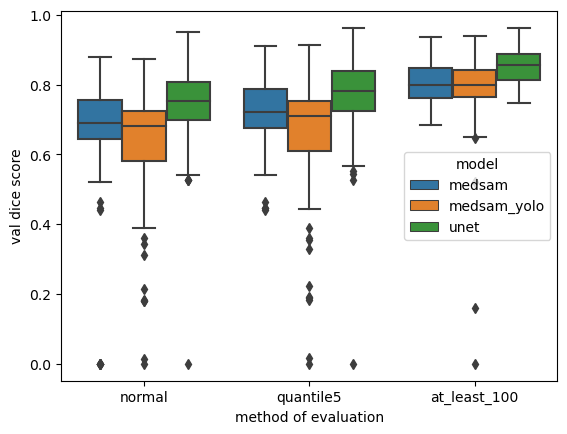

In [13]:
sns.boxplot(concat_df, x='method', y='dice_sensitivity', hue='model')
plt.ylabel('val dice score')
plt.xlabel('method of evaluation')